In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
# First, we get the data
dataset = pd.read_csv('/content/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [5]:
#Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

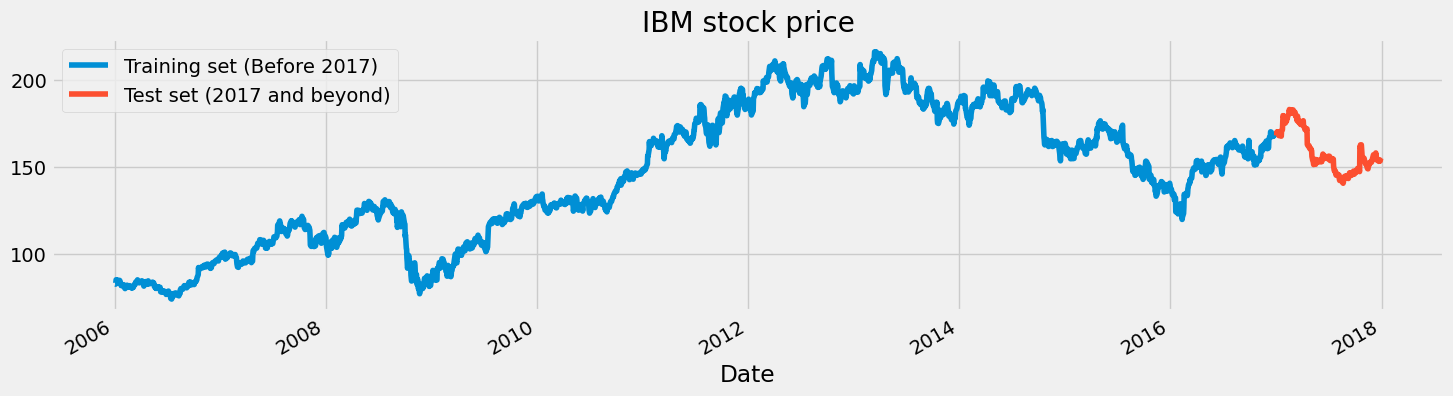

In [6]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 25s 159ms/step - loss: 0.0222
Epoch 2/50
85/85 [==============================] - 9s 106ms/step - loss: 0.0102
Epoch 3/50
85/85 [==============================] - 9s 106ms/step - loss: 0.0077
Epoch 4/50
85/85 [==============================] - 8s 100ms/step - loss: 0.0072
Epoch 5/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0059
Epoch 6/50
85/85 [==============================] - 11s 125ms/step - loss: 0.0061
Epoch 7/50
85/85 [==============================] - 9s 106ms/step - loss: 0.0053
Epoch 8/50
85/85 [==============================] - 8s 99ms/step - loss: 0.0049
Epoch 9/50
85/85 [==============================] - 9s 101ms/step - loss: 0.0045
Epoch 10/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0042
Epoch 11/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0040
Epoch 12/50
85/85 [==============================] - 9s 111ms/step - loss: 0.0038
Epoch 13/50
85/85 [====

In [13]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [14]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 31ms/step


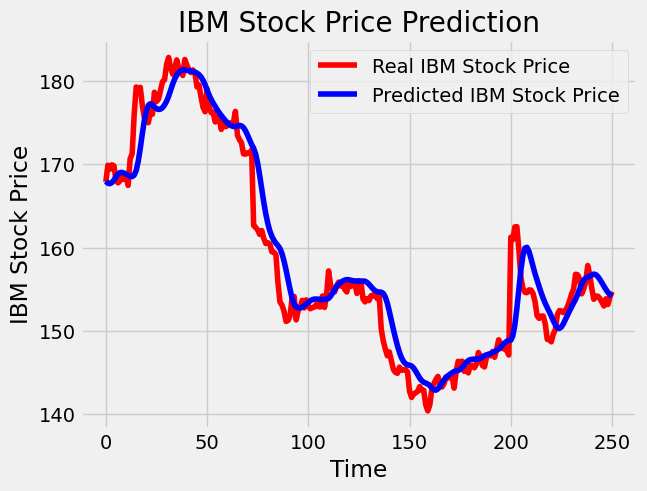

In [15]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [16]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.0184761671195.


In [17]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
19/19 [==============================] - 14s 334ms/step - loss: 0.1535
Epoch 2/50
19/19 [==============================] - 4s 204ms/step - loss: 0.0481
Epoch 3/50
19/19 [==============================] - 4s 188ms/step - loss: 0.0130
Epoch 4/50
19/19 [==============================] - 4s 207ms/step - loss: 0.0051
Epoch 5/50
19/19 [==============================] - 4s 218ms/step - loss: 0.0039
Epoch 6/50
19/19 [==============================] - 4s 192ms/step - loss: 0.0039
Epoch 7/50
19/19 [==============================] - 4s 191ms/step - loss: 0.0037
Epoch 8/50
19/19 [==============================] - 5s 240ms/step - loss: 0.0037
Epoch 9/50
19/19 [==============================] - 4s 194ms/step - loss: 0.0035
Epoch 10/50
19/19 [==============================] - 4s 188ms/step - loss: 0.0035
Epoch 11/50
19/19 [==============================] - 5s 245ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 4s 190ms/step - loss: 0.0030
Epoch 13/50
19/19 [=====

In [18]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 23ms/step


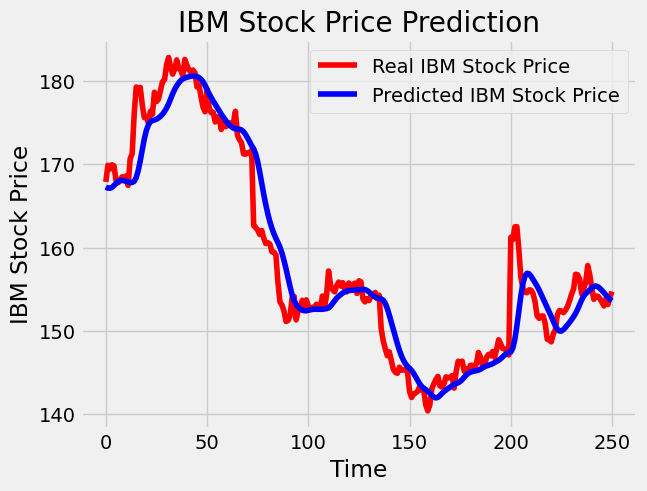

In [19]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.2379996455919575.
